In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import os
from os.path import isfile, join
import seaborn as sns
import pandas as pd

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [3]:
results_path = "..\\NativeApp\\results3"
result_files = [join(results_path, i) for i in os.listdir(results_path) if isfile(join(results_path, i))]
result_files.sort()
usr_res_files = [list(i) for j, i in itertools.groupby(result_files, lambda a: (a.split('\\')[-1].split('_')[0]))]

In [4]:
def process_files(files):
    return np.array([pd.read_csv(file, header=None).to_numpy() for file in files])
        
numpad_no_tactile = process_files(list(filter(lambda s: "Numpad_NoTactile" in s, result_files)))
numpad_tactile = process_files(list(filter(lambda s: "Numpad_Tactile" in s, result_files)))
text_no_tactile = process_files(list(filter(lambda s: "Text_NoTactile" in s, result_files)))
text_tactile = process_files(list(filter(lambda s: "Text_Tactile" in s, result_files)))


In [5]:
def format_response(response):
    split = response.split(" ")
    new = []
    original = []
    for e,c in enumerate(split):
        if e > 0 and c == '' and c == split[e-1]:
            continue
        elif c == '' or c == '\t':
            new.append(' ')
        else:
            new.append(c)
            
    return new

def reconstruct_string(chars):
    stack = []
    for char in chars:
        if char == '\x08':
            if stack:
                stack.pop()
        else:
            stack.append(char)
    return ''.join(stack)

def compute_avg_time(data):
    return np.mean(data[:,:,1].astype(np.float64), axis=1), np.std(data[:,:,1].astype(np.float64), axis=1)

def compute_avg_accuracy(data):
    all_accs = []
    for d in data:
        responses = list(map(format_response, d[:,0]))
        original_str = list(map(reconstruct_string, responses))
        all_accs.append([(len(orig)/len(response)) for response,orig in zip(responses, original_str)])
    return np.array(all_accs)

In [6]:
from __future__ import annotations
class PerformanceStats():
    def __init__(self, raw_response, mean_time, std_time, mean_accuracy, std_accuracy):
        self.raw_response = raw_response
        self.mean_time = mean_time
        self.std_time = std_time
        self.mean_accuracy = mean_accuracy
        self.std_accuracy = std_accuracy
        
    def __repr__(self):
        return f"mean_time: {self.mean_time}, std_time:{self.std_time}, mean_acc: {self.mean_accuracy}, std_acc: {self.std_accuracy}"

    #return array of those responses within 2 std times of mean
    def prune_results(self):
        max_time = self.mean_time + 2 * self.std_time
        min_time = self.mean_time - 2 * self.std_time
        pruned = []
        for entry in self.raw_response:
            if entry[1] > min_time and entry[1] < max_time:
                pruned.append(entry)
        return np.array(pruned)
        
    #returns time difference between this user's mean time and another objects
    #Compares average time of pruned sets. returns decimal between -1 and 1.
    def compare_time(self, other:PerformanceStats):
        pruned_mean_time = np.mean(self.prune_results()[:,1])
        other_pruned_mean_time = np.mean(np.mean(other.prune_results()[:,1]))
        return (pruned_mean_time - other_pruned_mean_time) / pruned_mean_time
    
    #returns accuracy difference normalised to the object being called.
    #inverted from time comparison as decrease in time is better whereas increase in accuracy is better.
    def compare_accuracy(self, other:PerformanceStats):
        pruned_mean_acc = np.mean(compute_avg_accuracy([self.prune_results()]))
        other_mean_acc = np.mean(compute_avg_accuracy([other.prune_results()]))
        return (other_mean_acc - pruned_mean_acc) / pruned_mean_acc

    
def create_obj(data):
    mean_time, std_time = compute_avg_time(data)
    all_accuracy = compute_avg_accuracy(data)
    mean_accuracy = np.mean(all_accuracy, axis=1)
    std_accuracy = np.std(all_accuracy, axis=1)
    return np.array([PerformanceStats(d,t,stdt,a,stda) for d,t,stdt,a,stda in zip(data, mean_time, std_time, mean_accuracy, std_accuracy)])

perf_numpad_no_tactile = create_obj(numpad_no_tactile)    
perf_numpad_tactile = create_obj(numpad_tactile)
perf_text_no_tactile = create_obj(text_no_tactile)
perf_text_tactile = create_obj(text_tactile)

In [7]:
time_comparison_numpad = np.array([e.compare_time(perf_numpad_tactile[i]) for i,e in enumerate(perf_numpad_no_tactile)])
time_comparison_text = np.array([e.compare_time(perf_text_tactile[i]) for i,e in enumerate(perf_text_no_tactile)])

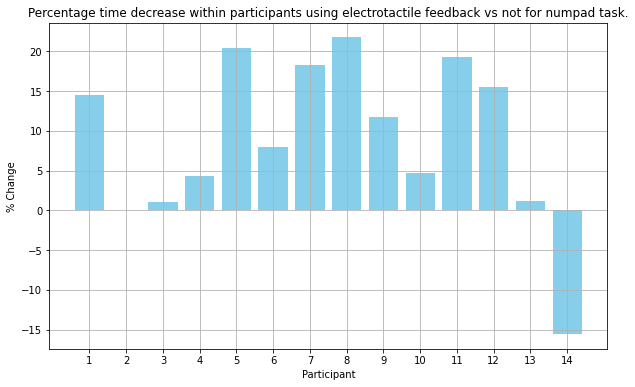

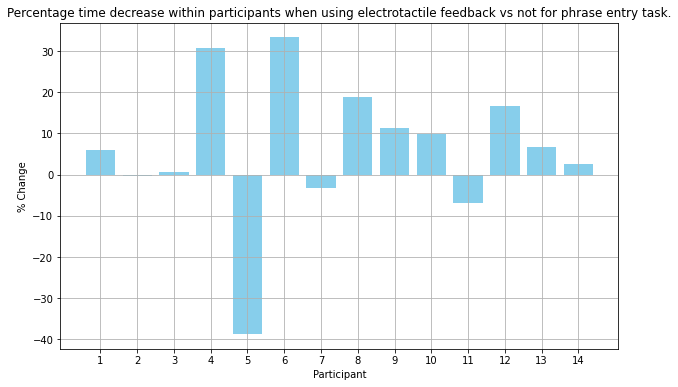

In [8]:
import time
def plot_bar_plot(data, title, save_fig=False):
    participant_ids = range(1,len(data)+1)
    plt.figure(figsize=(10, 6))
    plt.bar(participant_ids, data, color='skyblue')
    plt.xlabel('Participant')
    plt.ylabel('% Change')
    plt.title(title)
    plt.xticks(participant_ids)
    plt.grid(True)
    if save_fig:
        plt.savefig(fname=f"{time.strftime('%Y%m%d-%H%M%S')}.pdf", format='pdf')
    plt.show()
    
plot_bar_plot(time_comparison_numpad*100, 'Percentage time decrease within participants using electrotactile feedback vs not for numpad task.')
plot_bar_plot(time_comparison_text*100, 'Percentage time decrease within participants when using electrotactile feedback vs not for phrase entry task.')

In [9]:
print(f"Participants were on average {round(np.mean(time_comparison_numpad)*100, 2)}% faster when using electrotactile feedback vs not for the keypad task")
print(f"Participants were on average {round(np.mean(time_comparison_text)*100, 2)}% faster when using electrotactile feedback vs not for the phrase entry task")

Participants were on average 8.94% faster when using electrotactile feedback vs not for the keypad task
Participants were on average 6.23% faster when using electrotactile feedback vs not for the phrase entry task


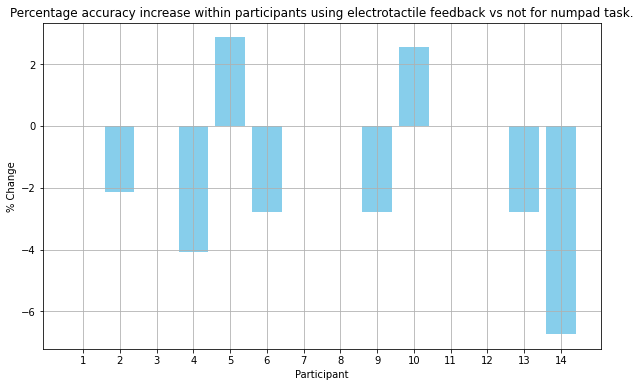

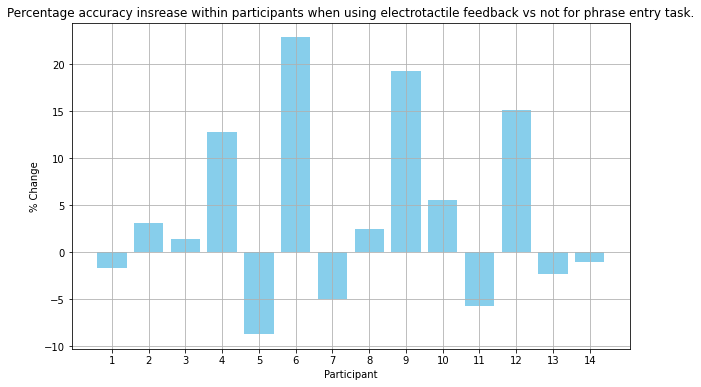

In [10]:
acc_comparison_numpad = np.array([e.compare_accuracy(perf_numpad_tactile[i]) for i,e in enumerate(perf_numpad_no_tactile)])
acc_comparison_text = np.array([e.compare_accuracy(perf_text_tactile[i]) for i,e in enumerate(perf_text_no_tactile)])

plot_bar_plot(acc_comparison_numpad*100, 'Percentage accuracy increase within participants using electrotactile feedback vs not for numpad task.')
plot_bar_plot(acc_comparison_text*100, 'Percentage accuracy insrease within participants when using electrotactile feedback vs not for phrase entry task.')

In [11]:
print(f"Participants were on average {round(np.mean(acc_comparison_numpad)*100, 2)}% more accurate when using electrotactile feedback for the keypad task")
print(f"Participants were on average {round(np.mean(acc_comparison_text)*100, 2)}% more accurate when using electrotactile feedback for the phrase entry task")

Participants were on average -1.13% more accurate when using electrotactile feedback for the keypad task
Participants were on average 4.16% more accurate when using electrotactile feedback for the phrase entry task


## Questionnaire analysis

In [12]:
def plot_wordmap(words, title):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(words)+" ")

    plt.figure(figsize = (5, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()

{'tingly': 5, 'light': 2, 'responsive': 2, 'sharp': 2, 'tickly': 2, 'tingle': 2, 'different': 1, 'exciting': 1, 'fun': 1, 'mild': 1, 'nice': 1, 'numb': 1, 'odd': 1, 'okay': 1, 'pleasant': 1, 'quick': 1, 'relax': 1, 'spelling': 1, 'stingy': 1, 'strange': 1, 'subtle': 1, 'suttle': 1, 'tactile': 1, 'tapping': 1, 'twingy': 1, 'uncomfortable': 1}


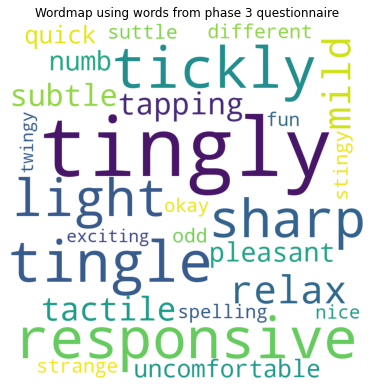

In [14]:
path = "..\\Questionnaire\\Electrotactile Feedback - Phase 3 (Responses).xlsx"
responses = pd.read_excel(path)
words = [i.split('-') for i in responses.iloc[:,6].to_numpy()]
all_words = []
for user_words in words:
    for word in user_words:
        if word.strip().find(' ') > -1:
            continue
        all_words.append(word.strip().lower())

        
unique, counts = np.unique(np.array(all_words), return_counts=True)
words_dict = {val: counts[i] for i, val in enumerate(unique)}  
print(dict(sorted(words_dict.items(), key=lambda item: -item[1])))

plot_wordmap(all_words, "Wordmap using words from phase 3 questionnaire")
        

In [37]:
#Sentiment analysis
import nltk
from nltk.corpus import sentiwordnet as swn

nltk.download('wordnet')
nltk.download('sentiwordnet')

def compute_happiness_score(word_list):
    if len(word_list) == 0:
        return 0
    
    total_happiness_score = 0
    for word in word_list:
        synsets = list(swn.senti_synsets(word))
        if not synsets:
            continue
        avg_pos_score = sum(synset.pos_score() for synset in synsets) / len(synsets)
        avg_neg_score = sum(synset.neg_score() for synset in synsets) / len(synsets)
        
        word_score = avg_pos_score - avg_neg_score
        total_happiness_score += word_score
    
    return total_happiness_score / len(word_list)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [38]:
score = compute_happiness_score(all_words)

print(f"Average sentiment score across all words: {score}")

Average sentiment score across all words: -0.014374109300021146
